# Hello Many Worlds - Creating Bell States and Cat States on IonQ Quantum Computer

## Setup

First, get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package included with this notebook using `pip`:

```bash
pip install qiskit_ionq_provider-0.0.1.dev0+45bd6b1-py3-none-any.whl
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [27]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer
from time import sleep

from qiskit_ionq_provider import IonQProvider 

with open(".ionqkey") as keyfile:
    key = keyfile.readline().strip('\n')

#Call provider and set token value
provider = IonQProvider(token=key)

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:


In [7]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7fdc5d643f10>()>,
 <IonQQPUBackend('ionq_qpu') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7fdc5d643f10>()>]

### Example - Bell State

For our first example, let's prepare a standard Bell state using Qiskit.

In [8]:
from qiskit import QuantumCircuit

# Create a bell state circuit.
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# Show the circuit:
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

Now run the circuit using IonQ's simulator backend:

In [9]:
from qiskit.providers.jobstatus import JobStatus

# Get an IonQ simulator backend to run circuits on:
backend = provider.get_backend("ionq_simulator")

# Then run the circuit:
job = backend.run(qc, shots=1000)

#save job_id
job_id_bell = job.job_id()

# Fetch the result:
result = job.result()

Last but not least, use Qiskit's built-in tools to render the results as a histogram:

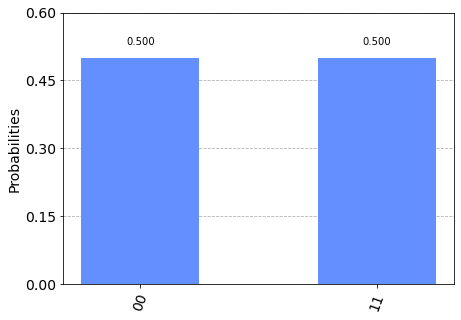

In [10]:
from qiskit.visualization import plot_histogram

plot_histogram(result.get_counts())

In [11]:
# Next get an IonQ hardware backend to run circuits on:
qpu_backend = provider.get_backend("ionq_qpu")

# Then run the circuit:
qpu_job_bell = qpu_backend.run(qc)

#Store job id
job_id_bell = qpu_job_bell.job_id()

The job will queue, and results will arrive once it's executed!

In [15]:
#Check if job is done
if qpu_job_bell.status() is JobStatus.DONE:
    
    print("Job status is DONE")
    
    # Fetch the result:
    qpu_result_bell = qpu_job_bell.result()
   
else:
    print("Job status is ", qpu_job_bell.status() )

Job status is DONE


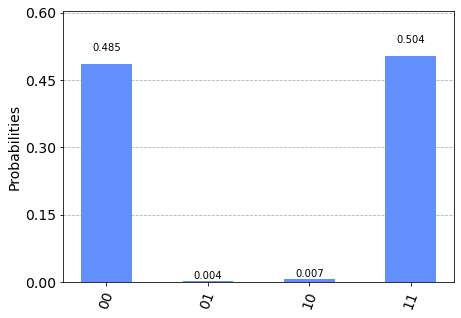

In [16]:
#If Job is finished, plot and validate results:
plot_histogram(qpu_result_bell.get_counts())

### Job History

Provider backends can also be used to retrieve previously run jobs:

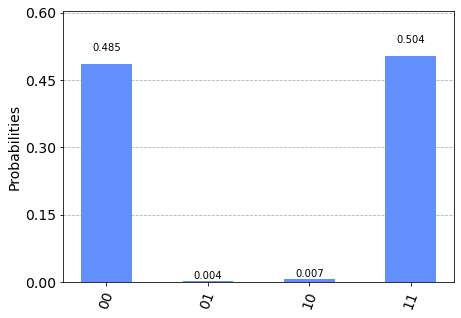

In [17]:
# Retrieve a previously executed job:
old_job = backend.retrieve_job(job_id_bell)

# Then render the old job results:
old_result = old_job.result()
plot_histogram(old_result.get_counts())

### Example - Cat State

Next let's generalize this to several qubits, also called a `cat state`

In [18]:
n=4
qc_cat = QuantumCircuit(n, n)
qc_cat.h(0)
for i in range(1,n):
    qc_cat.cx(0, i)

qc_cat.measure(range(n), range(n))

# Show the circuit:
qc_cat.draw()

┌───┐                     ┌─┐   
q_0: ┤ H ├──■────■───────■─────┤M├───
     └───┘┌─┴─┐  │  ┌─┐  │     └╥┘   
q_1: ─────┤ X ├──┼──┤M├──┼──────╫────
          └───┘┌─┴─┐└╥┘  │  ┌─┐ ║    
q_2: ──────────┤ X ├─╫───┼──┤M├─╫────
               └───┘ ║ ┌─┴─┐└╥┘ ║ ┌─┐
q_3: ────────────────╫─┤ X ├─╫──╫─┤M├
                     ║ └───┘ ║  ║ └╥┘
c: 4/════════════════╩═══════╩══╩══╩═
                     1       2  0  3

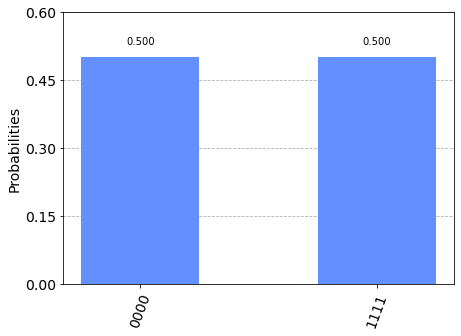

In [19]:
#Run the circuit on the simulator and plot the results
job_cat = backend.run(qc_cat)

#save job_id
job_id_cat = job_cat.job_id()

# Fetch the result:
result_cat = job_cat.result()

plot_histogram(result_cat.get_counts())


In [21]:
# Then run the circuit on the hardware:
qpu_job_cat = qpu_backend.run(qc_cat)

# save job id
qpu_job_id_cat = qpu_job_cat.job_id()



In [24]:
#Check if job is done
while qpu_job_cat.status() is JobStatus.QUEUED:
    sleep(1)
    
print("Job status is ", qpu_job_cat.status() )

if qpu_job_cat.status() is JobStatus.DONE:
    # Fetch the result:
    qpu_result_cat = qpu_job_cat.result()

Job status is  JobStatus.DONE


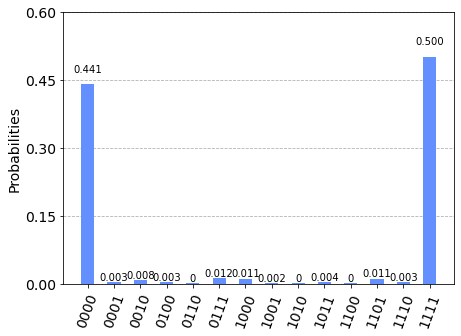

In [25]:
#If Job is finished, plot and validate results:
plot_histogram(qpu_result_cat.get_counts())